In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=3, suppress=True)

# Точные методы решения СЛАУ
Смотрим на принципы работы метода Гаусса (LU) и методов отражений/вращений/Грама-Шмидта (QR).

Все они рекурсивные: мы сводим систему **Ax=b** к системе меньшего порядка (с тремя векторами на плоскости). Но делаем это по-разному.

In [2]:
A0 = np.array([
    [5, 4, 3],
    [4, 3, 5],
    [3, 5, 4],
], dtype='float')

b0 = np.array([6, 6, 6], dtype='float')

Ab0 = np.c_[A0, b0]  # расширенная матрица

o = np.zeros(3)  # начало координат

In [3]:
# рисовалка векторов
def plot_vec(ax, a, b, *args, **kwargs):
    ax.plot([a[0], b[0]], 
            [a[1], b[1]], 
            [a[2], b[2]], *args, **kwargs)

### Векторы СЛАУ
Решение системы - коэффициенты разложения вектора **b** (чёрного) по базису из трёх ветных.

В следующих примерах мы будем избавляться от первого вектора системы (синего).

Векторы, составляющие систему низшего порядка, будут обозначены пунктиром. В каждом случае это три компланарных вектора: два красных и один чёрный.

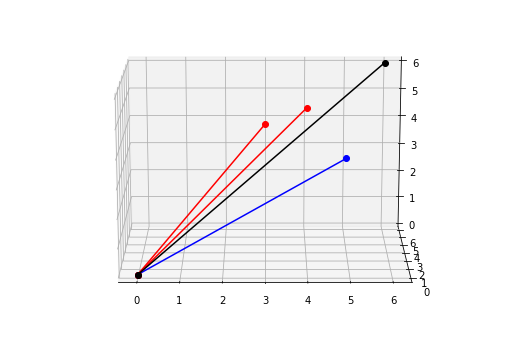

In [4]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
colors = 'brrk'
for i, col in enumerate(colors):
    plot_vec(ax, o, Ab0[:, i], f'{col}o-')
ax.azim, ax.elev = -90, 15

### Итерация метода Гаусса
Вообще-то это преобразование строк расширенной матрицы, поэтому в нашем трёхмерном пространстве будет трудно интерпретировать.

Каждый из векторов преобразуется в плоскости, которую он составляет с синим. Синий становится единичным ортом. Затем остальные проецируются вдоль этого орта.

Это преобразование неортогональное.

In [5]:
A1, b1 = A0.copy(), b0.copy()
Ab1 = np.c_[A1, b1]

Ab1[0, :] /= Ab1[0, 0]
Ab1[1, :] -= Ab1[0, :] * Ab1[1, 0]
Ab1[2, :] -= Ab1[0, :] * Ab1[2, 0]

print(Ab1)

# Проецируем
Ab2 = Ab1.copy()
Ab2[0, :] = 0

[[ 1.   0.8  0.6  1.2]
 [ 0.  -0.2  2.6  1.2]
 [ 0.   2.6  2.2  2.4]]


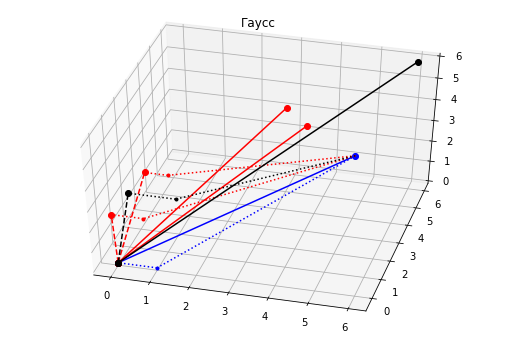

In [6]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

colors = 'brrk'
for i, col in enumerate(colors):
    plot_vec(ax, o, Ab0[:, i], f'{col}o-')
    plot_vec(ax, Ab0[:, 0], Ab1[:, i], f'{col}:')
    plot_vec(ax, o, Ab1[:, i], f'{col}.')
    plot_vec(ax, Ab1[:, i], Ab2[:, i], f'{col}:')
    plot_vec(ax, o, Ab2[:, i], f'{col}o--')
ax.set_title('Гаусс')
ax.azim, ax.elev = -75, 45

### Итерация метода отражений
Отражаем все векторы от такой плоскости, чтобы синий при этом стал направлен вдоль оси абсцисс. Пересечения с этой плоскостью выделены жёлтым.

Затем остальные проецируются вдоль этого орта.

Это преобразование ортогональное.

In [7]:
A1, b1 = A0.copy(), b0.copy()
y = A1[:, 0]
z = np.eye(3)[:, 0]
alpha = np.linalg.norm(y) / np.linalg.norm(z)
w = np.array(y - alpha*z, ndmin=2)
w /= np.linalg.norm(w)
U = np.eye(3) - 2*w.T@w

A1 = U @ A1
b1 = U @ b1

Ab1 = np.c_[A1, b1]
print(Ab1)

# Проецируем
Ab2 = Ab1.copy()
Ab2[0, :] = 0

[[ 7.071  6.647  6.647 10.182]
 [ 0.    -2.112 -2.043 -2.078]
 [ 0.     1.166 -1.282 -0.058]]


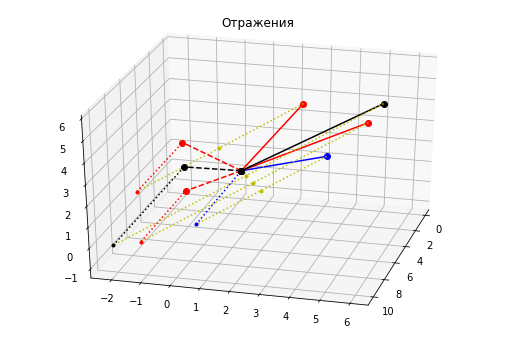

In [8]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

colors = 'brrk'
for i, col in enumerate(colors):
    plot_vec(ax, o, Ab0[:, i], f'{col}o-')
    plot_vec(ax, o, (Ab0[:, i] + Ab1[:, i])/2 , 'y.')
    plot_vec(ax, Ab0[:, i], Ab1[:, i] , 'y:')
    plot_vec(ax, o, Ab1[:, i], f'{col}.')
    plot_vec(ax, Ab1[:, i], Ab2[:, i] , f'{col}:')
    plot_vec(ax, o, Ab2[:, i], f'{col}o--')
ax.set_title('Отражения')
ax.azim, ax.elev = 15, 30

### Итерация метода вращений
Дважды вертим так, чтобы обнулить сначала вторую, а потом третью компоненту синего вектора.

Затем остальные проецируются вдоль этого орта.

Это преобразование ортогональное.

In [9]:
A1, b1 = A0.copy(), b0.copy()

# Поворот по осям 1-2
R = np.eye(3)
c = A1[0,0] / np.linalg.norm(A1[:2, 0])
s = A1[1,0] / np.linalg.norm(A1[:2, 0])
R[:2, :2] = [[c, s], [-s, c]]

A1 = R @ A1
b1 = R @ b1
Ab1 = np.c_[A1, b1]

# Поворот по осям 1-3
R = np.eye(3)
c = A1[0,0] / np.linalg.norm(A1[::2, 0])
s = A1[2,0] / np.linalg.norm(A1[::2, 0])
R[::2, ::2] = [[c, s], [-s, c]]

A2 = R @ A1
b2 = R @ b1
Ab2 = np.c_[A2, b2]
print(Ab2)

# Проецируем
Ab3 = Ab2.copy()
Ab3[0, :] = 0

[[ 7.071  6.647  6.647 10.182]
 [ 0.    -0.156  2.03   0.937]
 [ 0.     2.407  1.303  1.855]]


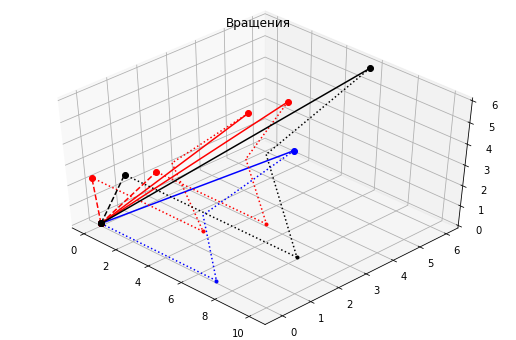

In [10]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

colors = 'brrk'
for i, col in enumerate(colors):
    plot_vec(ax, o, Ab0[:, i], f'{col}o-')
    plot_vec(ax, Ab0[:, i], Ab1[:, i] , f'{col}:')
    plot_vec(ax, Ab1[:, i], Ab2[:, i] , f'{col}:')
    plot_vec(ax, o, Ab2[:, i], f'{col}.')
    plot_vec(ax, Ab2[:, i], Ab3[:, i] , f'{col}:')
    plot_vec(ax, o, Ab3[:, i], f'{col}o--')
ax.set_title('Вращения')
ax.azim, ax.elev = -45, 45

### Итерация метода Грама-Шмидта
Проецируем всё на плоскость, ортогональную синему.

Формально тут вообще ничего не преобразуется, синий вообще на месте остаётся.

In [11]:
A1, b1 = A0.copy(), b0.copy()

def proj(a, b):
    return (a@b) / (b@b) * b

Ab1 = np.c_[A1, b1]
print(Ab1)

for i in range(1, 4):
    p = proj(Ab1[:, i], Ab1[:, 0])
    Ab1[:, i] -= p

[[5. 4. 3. 6.]
 [4. 3. 5. 6.]
 [3. 5. 4. 6.]]


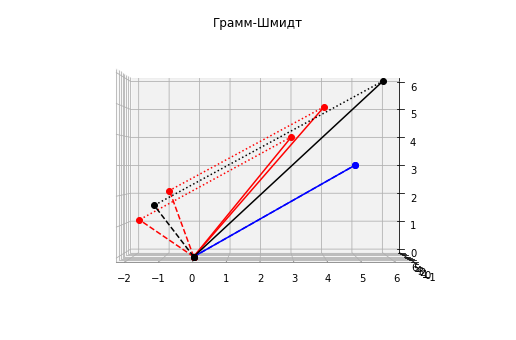

In [12]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

colors = 'brrk'
for i, col in enumerate(colors):
    plot_vec(ax, o, Ab0[:, i], f'{col}o-')
    plot_vec(ax, Ab0[:, i], Ab1[:, i], f'{col}:')
    plot_vec(ax, o, Ab1[:, i] , f'{col}o--')
ax.set_title('Грамм-Шмидт')
ax.azim, ax.elev = -90, 0